### Table of Contents

#### 1. Baseline Model

  1.1 Drop Dummy Variables

  1.2 Baseline Model

#### 2. Linear Regression Fine Tuning with PCA

  2.1 PC Selections

  2.2 Wide Range Hyperparameter Fine Tuning using Pipeline

  2.3 Narrower Range Hyperparameter Fine Tuning using Pipeline

  2.4 Interpreting PCA-Transformed Data

#### 3. Linear Regression Fine Tuning - Checking for Assumptions

  3.1 Linearity: Check the correlation between Xs and y.

  3.2 Multicollinearity: Check the correlations between Xs.

  3.3 Residuals: Are they normally distributed?

  3.4 Homoscedasticity: Is the variance of residuals the same for any value of X?
  
#### 4. Conclusion

#### 5. Other Models (KNN, Random Forest, Neural Network)

### Data Dictionary

The dataset is created by joining 5 tables and added dummy columns. For an overview of the data, please refer to the following data dictionary:

#### 1. sales columns

**store_nbr**: the store at which the products are sold.

**family**: the type of product sold.

**sales**: the total sales for a product family at a particular store on a given date. Fractional values are possible since products can be sold in

fractional units (e.g., 1.5 kg of cheese, as opposed to 1 bag of chips).

**onpromotion**: the total number of items in a product family that were being promoted at a store on a given date.

#### 2. stores columns

Store metadata, including **city, state, type, and cluster**.

cluster is a grouping of similar stores.

#### 3. oil column

**Daily oil price**. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 4. holidays_events columns

Holidays and Events, with metadata

NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to

another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for 

the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which 

means it was celebrated on 2012-10-12. 

Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made 

up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

**Additional** holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (m aking Christmas Eve a holiday).

#### 5. Additional Notes on events

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which 

greatly affected supermarket sales for several weeks after the earthquake

In [141]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# read data
df=pd.read_csv("full_data.csv")
df.head()

,sales,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_20,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
0,1091.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
1,1060.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
2,579.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
3,2652.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
4,0.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0


### 1. Baseline Model

#### 1.1 Drop the dummy variables with the least information

In [143]:
fam = df.filter(like='family')
fam.sum().sort_values()

family_BEVERAGES    29365
family_CLEANING     29365
family_DAIRY        29365
family_GROCERY I    29365
family_PRODUCE      29365
dtype: int64

In [144]:
df_quito = pd.read_csv('quito_whole.csv')
df_fam_group = df_quito.groupby('family').sum()['sales'].sort_values()
df_fam_group

family
DAIRY        3.629945e+07
CLEANING     4.473651e+07
PRODUCE      7.337649e+07
BEVERAGES    1.139910e+08
GROCERY I    1.678638e+08
Name: sales, dtype: float64

**Drop family_DAIRY: Though all families carry the same amount of information, dairy has the lowest sales**

In [145]:
store_nbr = df.filter(like='store_nbr_')
store_nbr.sum().sort_values()

store_nbr_20    4560
store_nbr_18    7850
store_nbr_17    8390
store_nbr_10    8395
store_nbr_7     8395
store_nbr_1     8400
store_nbr_6     8400
store_nbr_8     8400
store_nbr_9     8400
store_nbr_3     8400
store_nbr_4     8400
store_nbr_45    8405
store_nbr_46    8405
store_nbr_47    8405
store_nbr_48    8405
store_nbr_49    8405
store_nbr_2     8405
store_nbr_44    8405
dtype: int64

**Drop "store_nbr_20"**

In [146]:
descr = df.filter(like='description_eng_')
descr.sum().sort_values()

description_eng_RECOVERY DAY OF THE DEAD                     85
description_eng_World Football Inauguration Brazil           85
description_eng_Deceased day                                 85
description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-SUIZA      85
description_eng_WORLD OF FOOTBALL BRAZIL: Ecuador-France     85
                                                           ... 
description_eng_MOTHER DAY-1                                440
description_eng_Holy Friday                                 440
description_eng_Mother's Day                                440
description_eng_Labor Day                                   440
description_eng_Carnival                                    880
Length: 69, dtype: int64

**Drop "description_eng_RECOVERY DAY OF THE DEAD"**

In [147]:
str_type = df.filter(like='sto_type')
str_type.sum().sort_values()

sto_type_C    16785
sto_type_B    20810
sto_type_A    50430
sto_type_D    58800
dtype: int64

**Drop "sto_type_C"**

In [148]:
cluster = df.filter(like='cluster')
cluster.sum().sort_values()

cluster_16     7850
cluster_12     8390
cluster_15     8395
cluster_9      8400
cluster_5      8405
cluster_6     12960
cluster_11    16810
cluster_8     25195
cluster_13    25205
cluster_14    25215
dtype: int64

**Drop "cluster_16"**

In [149]:
holi = df.filter(like='holi_type')
holi.sum().sort_values()

holi_type_Bridge         255
holi_type_Work Day       425
holi_type_Transfer       620
holi_type_Additional    2890
holi_type_Holiday       3495
holi_type_Event         4940
dtype: int64

**Drop "holi_type_Bridge"**

In [150]:
# Drop the dummies
drop_cols = ['family_DAIRY', 'store_nbr_20', 'description_eng_RECOVERY DAY OF THE DEAD', 'sto_type_C', 'cluster_16', 'holi_type_Bridge']
df_clean = df.drop(columns=drop_cols)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146825 entries, 0 to 146824
Columns: 117 entries, sales to weekend
dtypes: float64(3), int64(114)
memory usage: 131.1 MB


#### 1.2 Linear Regression Baseline Model

In [151]:
# train_test split
from sklearn.model_selection import train_test_split
X=df_clean.drop("sales", axis=1)
y=df_clean["sales"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [152]:
# scale the data
from sklearn.preprocessing import StandardScaler
# scale the dataset
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [153]:
# fit the baseline linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_ss,y_train)
score1 = lr.score(X_train_ss, y_train)
score2 = lr.score(X_test_ss, y_test)
print(f"Baseline Linear Regression R-squared train score:", round(score1,2))
print(f"Baseline Linear Regression R-squared test score:", round(score2,2))

Baseline Linear Regression R-squared train score: 0.68
Baseline Linear Regression R-squared test score: 0.69


### 2. Linear Regression Fine Tuning - PCA

#### 2.1 PC selections

Because we have 116 features, we need to reduce the dataset's dimensions using **PCA**, which will also reduce multicollinearity.

In [154]:
# import library
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

In [155]:
# apply pca
my_pca = PCA()
X_train_pca = my_pca.fit_transform(X_train_ss)
X_test_pca = my_pca.transform(X_test_ss)

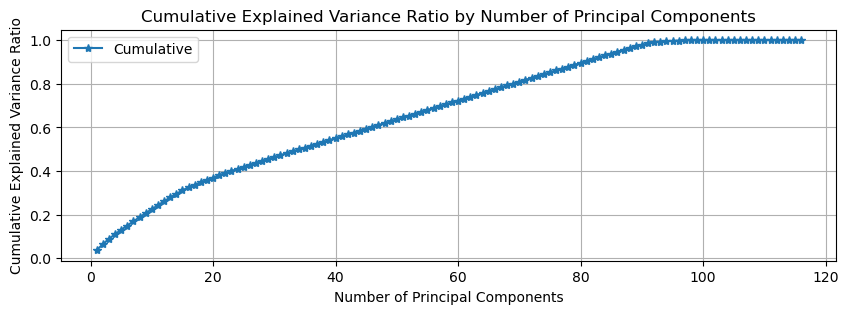

In [156]:
# Visualize PCA variance explained ratio
plt.figure(figsize=(10,3))
plt.plot(range(1, len(my_pca.components_)+1), my_pca.explained_variance_ratio_.cumsum(), label="Cumulative", marker="*")
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.legend()
plt.show()

**To achieve sufficient variance, the number of PCs should be close to 90. Let's use 85, 90, 95, 100 in grid search to find the optimal number of PCs.**

Using grid search for model fine tuning. Hyperparameters are scalers, the numbers of PCs, regularization.

In [157]:
# build pipeline
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('regularization', Lasso())]
pipe = Pipeline(estimators)

#### 2.2 Wide range hyperparameter fine tuning using pipeline

**To start with, we will use a wider range of hyperparameter values then dive deeper from there**

In [158]:
# set up parameters
params_high_level = [{
          'normalise': [StandardScaler(), RobustScaler()],
          'reduce_dim__n_components':[85,100],
          'regularization': [Lasso()],
          'regularization__alpha': [0.001,1,100]
         },
         {
          'normalise': [StandardScaler(), RobustScaler()],
          'reduce_dim__n_components':[85,100],
          'regularization': [Ridge()],
          'regularization__alpha': [0.001,1,100]
         }]

# apply grid_search
grid_search = GridSearchCV(pipe, param_grid=params_high_level, scoring='r2', return_train_score=True)

In [159]:
# fit the grid search
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('reduce_dim', PCA()),
                                       ('regularization', Lasso())]),
             param_grid=[{'normalise': [StandardScaler(), RobustScaler()],
                          'reduce_dim__n_components': [85, 100],
                          'regularization': [Lasso()],
                          'regularization__alpha': [0.001, 1, 100]},
                         {'normalise': [StandardScaler(), RobustScaler()],
                          'reduce_dim__n_components': [85, 100],
                          'regularization': [Ridge(alpha=1)],
                          'regularization__alpha': [0.001, 1, 100]}],
             return_train_score=True, scoring='r2')

**Get the best parameters for deep dive**

In [160]:
# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator: ", best_estimator)

Best parameters found:  {'normalise': RobustScaler(), 'reduce_dim__n_components': 100, 'regularization': Ridge(alpha=1), 'regularization__alpha': 1}
Best estimator:  Pipeline(steps=[('normalise', RobustScaler()),
                ('reduce_dim', PCA(n_components=100)),
                ('regularization', Ridge(alpha=1))])


In [161]:
# Evaluate the robustness of the optimized model
cv_results = grid_search.cv_results_

# Get the mean training score and mean validation score
mean_train_score = np.mean(cv_results['mean_train_score'])
mean_validation_score = np.mean(cv_results['mean_test_score'])

print(f"Mean Training Score: {mean_train_score:.2f}")
print(f"Mean Validation Score: {mean_validation_score:.2f}")

Mean Training Score: 0.64
Mean Validation Score: 0.64


#### 2.3 Narrower range hyperparameter fine tuning using pipeline

**Now that we have the best params, we can use these params and find the optimal regularization alpha**

In [162]:
# rebuild pipeline
estimators2 = [('normalise', RobustScaler()),
              ('reduce_dim', PCA()),
              ('regularization', Ridge())]
pipe = Pipeline(estimators2)

In [163]:
# set up parameters
params2 = [{
          'reduce_dim__n_components':[90,95,100],
          'regularization__alpha': [1,10]
         }]

# apply grid_search
grid_search2 = GridSearchCV(pipe, param_grid=params2, scoring='r2', return_train_score=True)

In [164]:
# fit the grid search
grid_search2.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalise', RobustScaler()),
                                       ('reduce_dim', PCA()),
                                       ('regularization', Ridge())]),
             param_grid=[{'reduce_dim__n_components': [90, 95, 100],
                          'regularization__alpha': [1, 10]}],
             return_train_score=True, scoring='r2')

In [165]:
# Get the best parameters and estimator
best_params2 = grid_search2.best_params_
best_estimator2 = grid_search2.best_estimator_

print("Best parameters found: ", best_params2)
print("Best estimator: ", best_estimator2)

Best parameters found:  {'reduce_dim__n_components': 95, 'regularization__alpha': 10}
Best estimator:  Pipeline(steps=[('normalise', RobustScaler()),
                ('reduce_dim', PCA(n_components=95)),
                ('regularization', Ridge(alpha=10))])


In [166]:
# Evaluate the robustness of the optimized model
cv_results2 = grid_search2.cv_results_

# Get the mean training score and mean validation score
mean_train_score = np.mean(cv_results2['mean_train_score'])
mean_validation_score = np.mean(cv_results2['mean_test_score'])

print(f"Mean Training Score: {mean_train_score:.2f}")
print(f"Mean Validation Score: {mean_validation_score:.2f}")

Mean Training Score: 0.68
Mean Validation Score: 0.68


In [167]:
# Get the test score
test_score = best_estimator2.score(X_test, y_test)

print(f"Test Score: {test_score:.2f}")

Test Score: 0.69


We reduced features from 116 to 95 and the R-squared score remained at 0.69. The reason for low pc reduction might be due to the weak corrrelations between the features. Additionally, a robust model with a low R-squared score might indicate that Linear Regression is not suitable for sales prediction.
For now, we can move on to principal component analysis to better understand the features leading to the predicted results. After that, we can test the assumptions by manually reduce features.

#### 2.4 Interpreting PCA transformed data

First, let's find the top 10 principal components with the highest coefficients and then examine the loadings with the highest coefficients for each of those PCs.

In [168]:
ridge_coef = best_estimator2.named_steps['regularization'].coef_
ridge_coef = pd.DataFrame(ridge_coef, index = [f"PC{i+1}" for i in range(len(ridge_coef))], columns=["coefficient"])
ridge_coef.head(5)

,coefficient
PC1,448.906001
PC2,1449.601411
PC3,-423.663188
PC4,1079.124208
PC5,306.888308


In [169]:
# order by absolute value
ridge_coef["abs_coef"] = ridge_coef["coefficient"].abs()
ridge_sorted = ridge_coef.sort_values(by="abs_coef", ascending=False)
# select the top 10 coefficients(positive and negative)
ridge_sorted.head(10)
ridge_top = ridge_sorted.head(10)
ridge_top

,coefficient,abs_coef
PC28,-4133.276796,4133.276796
PC13,2290.887486,2290.887486
PC87,2038.238068,2038.238068
PC89,-1893.426900,1893.426900
PC84,1788.840702,1788.840702
PC10,-1679.437162,1679.437162
PC2,1449.601411,1449.601411
PC46,1334.457691,1334.457691
PC39,-1331.721228,1331.721228
PC31,-1313.409292,1313.409292


Now that we get the top 10 PCs with highest absolute coefficients, we can examine the top loadings of each PC.

In [170]:
pcs = ridge_top.index
pcs = pcs.tolist()
pcs

['PC28', 'PC13', 'PC87', 'PC89', 'PC84', 'PC10', 'PC2', 'PC46', 'PC39', 'PC31']

In [171]:
# check for each PCs' loadings
load_coef = best_estimator2.named_steps['reduce_dim'].components_
load_coef = pd.DataFrame(load_coef, index = [f"PC{i+1}" for i in range(len(load_coef))], columns=X_train.columns)
load_coef.head()

,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,store_nbr_4,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
PC1,0.986796,0.018695,-0.081235,-0.002182,-0.004416,-0.002365,-0.002043,-0.001130,0.000574,-0.001174,...,-0.000213,-0.000042,-0.000101,-0.000117,0.000102,0.131492,0.016270,0.000472,0.008559,-0.012856
PC2,-0.010362,0.694806,0.038964,-0.063588,-0.051478,-0.038196,-0.039713,-0.051224,-0.004254,-0.055798,...,0.000257,-0.000068,0.000194,-0.000062,0.000521,-0.060705,0.040190,-0.013305,-0.064212,0.077891
PC3,0.142224,-0.015703,0.565065,0.012289,-0.007471,-0.003529,-0.004070,0.013673,0.014769,0.010050,...,0.001313,0.001610,0.000528,0.000675,0.001413,-0.759206,0.230978,0.015257,0.040276,-0.047538
PC4,-0.010819,0.346831,-0.067022,0.054820,-0.095519,-0.079269,-0.102911,0.068155,0.136602,0.028912,...,0.000348,-0.000421,0.000584,-0.000370,0.001320,0.077301,0.061189,-0.053490,-0.265207,0.281718
PC5,0.024513,-0.095338,0.043281,-0.019552,0.049504,0.045155,0.074781,-0.024144,-0.052533,-0.007856,...,0.000112,-0.000609,0.001197,-0.000722,0.001335,-0.066669,0.076375,0.086666,-0.627209,0.619729


In [172]:
# select the top PCs with the loadings
top_pc_load = load_coef[load_coef.index.isin(pcs)]
top_pc_load = top_pc_load.T
top_pc_load.head()

,PC2,PC10,PC13,PC28,PC31,PC39,PC46,PC84,PC87,PC89
onpromotion,-0.010362,-0.000211,-0.042709,0.011515,0.000180,-0.000088,0.000374,-0.000038,0.000325,0.000070
store_trans,0.694806,-0.005592,0.148622,0.003062,-0.243257,0.006927,0.019882,-0.001858,-0.002999,0.001505
dcoilwtico_interpolated,0.038964,-0.000610,-0.061300,-0.049790,0.031511,0.000607,-0.000903,0.001989,0.000145,-0.004181
store_nbr_1,-0.063588,-0.001897,0.064133,0.003313,-0.063017,0.001335,0.003662,-0.000496,-0.000350,0.000436
store_nbr_10,-0.051478,0.005092,-0.117201,0.004293,-0.108322,0.002170,0.006339,-0.000564,-0.000941,0.000513


Due to the fact that each PC contains 116 loadings and it would be impossible for all the PCs to have the same loadings as top 5 most important features. We can check each PC's top 5 (inclues both positive and negative ones) loadings.

In [173]:
def top_loadings(df, top_n=5):
    top_pcs_with_top_features = {}
    for col in df.columns:
        # sort the features based on the absolute value of the coefficients
        sorted_features = df[col].abs().sort_values(ascending=False).head(top_n).index
        sorted_coefs_abs = df[col].abs().sort_values(ascending=False).head(top_n).values
        sorted_coefs = df[col].reindex(sorted_features).head(top_n).values
        top_pcs_with_top_features[col] = list(zip(sorted_features, sorted_coefs))
    return  top_pcs_with_top_features

top_loadings(top_pc_load, top_n=5)

{'PC2': [('store_trans', 0.6948057499253505),
  ('sto_type_A', 0.46772375087807505),
  ('sto_type_D', -0.2945898737023361),
  ('cluster_14', 0.2433963775104178),
  ('cluster_13', -0.16851025417236118)],
 'PC10': [('family_PRODUCE', 0.7911072656084052),
  ('family_BEVERAGES', -0.5439314654295128),
  ('family_GROCERY I', -0.27719766543105795),
  ('family_CLEANING', 0.030143480835988813),
  ('cluster_13', -0.010464600921399704)],
 'PC13': [('family_GROCERY I', 0.6177943263850232),
  ('family_CLEANING', -0.4783242301475049),
  ('family_BEVERAGES', -0.24378797086708553),
  ('cluster_13', 0.21695547204420873),
  ('sto_type_B', 0.18939161500925084)],
 'PC28': [('family_GROCERY I', -0.508425057486837),
  ('family_PRODUCE', -0.49953815471090657),
  ('family_BEVERAGES', -0.49471199362882956),
  ('family_CLEANING', -0.4901455971286724),
  ('year', -0.05420216837063192)],
 'PC31': [('store_nbr_9', -0.5306187941275655),
  ('holi_type_Additional', 0.43379510553099054),
  ('cluster_6', 0.315851971957

#### Conclusion:

**Of the top 10 PCs, PC2 is affected positively by store transactions and store_type_A; negatively by store_typeD; PC10, PC13, and PC28 are mainly correlated to product categories; PC31 is affected by store number and additional holidays; PC39 by Mother's Day, World Cup, and Christmas; PC46 by Independence Day, Day of the Dead, and pre-Christmas days; and PC84, PC87, and PC89 by earthquakes.**

### 3. Linear Regression Fine Tuning - Checking for assumptions

#### 3.1 Model Evaluations

- **Linearity**: Check the correlation between Xs and y.
- **Multicollienearity**: Check the correlations between Xs.

In [174]:
# Use scaled X_train data to exam multicollinearity
df_X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
df_X_train_ss

,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,store_nbr_4,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
0,-0.450467,-0.967743,-1.039822,-0.246591,-0.24729,-0.246475,4.213620,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.100534,1.421398,0.150013,-0.077661,-0.633313
1,-0.450467,0.486358,-1.477255,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.844020,-1.548671,1.175831,-0.077661,-0.633313
2,-0.450467,-0.950752,1.548811,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,4.074266,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,-0.642951,-0.063637,0.150013,-0.077661,-0.633313
3,0.406591,-0.515237,-0.645390,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,1.587505,-1.548671,-0.647846,-0.077661,-0.633313
4,-0.417504,0.632125,-1.411581,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.844020,-1.548671,-0.191927,1.028844,-0.633313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117455,1.988854,0.602614,-0.841629,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.844020,-0.063637,1.289811,-0.630913,-0.633313
117456,0.901048,0.390669,-0.668714,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.844020,1.124391,-0.077947,-1.184166,1.578998
117457,-0.384540,1.059591,-1.078522,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,0.844020,-0.657650,0.263992,-0.630913,-0.633313
117458,0.868085,1.507626,-0.547270,-0.246591,-0.24729,-0.246475,-0.237326,-0.246591,-0.246436,-0.245443,...,-0.034544,-0.034668,-0.023349,-0.024244,-0.048088,1.587505,-0.954657,-1.445705,1.582097,-0.633313


In [175]:
# calculate correlation matrix
corr_matrix = df_X_train_ss.corr()
corr_matrix 

,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,store_nbr_4,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
onpromotion,1.000000,0.055571,-0.328261,-0.019912,-0.042728,-0.022349,-0.019535,-0.009534,0.006035,-0.009866,...,-0.013316,-0.001295,-0.009255,-0.010504,0.005292,0.420592,0.071767,0.002409,0.043154,-0.066196
store_trans,0.055571,1.000000,-0.001343,-0.198380,-0.317544,-0.231485,-0.233725,-0.110841,0.171379,-0.201723,...,0.005602,-0.006923,0.006166,-0.005481,0.011639,-0.008058,0.068125,-0.025655,-0.133944,0.184362
dcoilwtico_interpolated,-0.328261,-0.001343,1.000000,0.004796,0.004119,0.006050,0.018458,0.007253,0.006635,0.005151,...,0.049776,0.049060,0.031246,0.037787,-0.007308,-0.831633,0.011460,-0.003377,0.001711,-0.000032
store_nbr_1,-0.019912,-0.198380,0.004796,1.000000,-0.060979,-0.060778,-0.058522,-0.060807,-0.060769,-0.060524,...,0.001035,-0.001145,0.000520,-0.002955,-0.000408,-0.005979,0.001462,0.002319,-0.000691,0.000532
store_nbr_10,-0.042728,-0.317544,0.004119,-0.060979,1.000000,-0.060951,-0.058688,-0.060979,-0.060941,-0.060696,...,-0.001131,0.001978,0.002054,0.000036,-0.000470,-0.003767,-0.001957,0.000016,0.001472,-0.000384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
year,0.420592,-0.008058,-0.831633,-0.005979,-0.003767,-0.005295,-0.018569,-0.005842,-0.005276,-0.004472,...,-0.022210,-0.022290,-0.015012,-0.015588,-0.014163,1.000000,-0.148483,-0.012675,-0.000142,-0.000073
month,0.071767,0.068125,0.011460,0.001462,-0.001957,0.000954,-0.014540,0.000178,0.002559,0.002502,...,0.008062,0.008090,0.005449,-0.001543,0.082635,-0.148483,1.000000,-0.007463,-0.003891,-0.002268
day,0.002409,-0.025655,-0.003377,0.002319,0.000016,-0.001192,-0.001309,0.000724,-0.001754,0.002267,...,-0.044063,-0.028513,-0.009804,-0.010180,-0.053078,-0.012675,-0.007463,1.000000,0.002085,-0.001612
weekday,0.043154,-0.133944,0.001711,-0.000691,0.001472,0.000217,-0.000045,0.000018,-0.000486,0.001326,...,0.007556,0.006286,-0.027649,0.024943,-0.009821,-0.000142,-0.003891,0.002085,1.000000,-0.749948


In [176]:
# mask the repeated values
mask = np.triu(np.ones(corr_matrix.shape), k=0).astype(bool)
corr_matrix_masked = corr_matrix.mask(mask)
corr_matrix_masked

,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,store_nbr_4,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
onpromotion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_trans,0.055571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dcoilwtico_interpolated,-0.328261,-0.001343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr_1,-0.019912,-0.198380,0.004796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr_10,-0.042728,-0.317544,0.004119,-0.060979,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
year,0.420592,-0.008058,-0.831633,-0.005979,-0.003767,-0.005295,-0.018569,-0.005842,-0.005276,-0.004472,...,-0.022210,-0.022290,-0.015012,-0.015588,-0.014163,NaN,NaN,NaN,NaN,NaN
month,0.071767,0.068125,0.011460,0.001462,-0.001957,0.000954,-0.014540,0.000178,0.002559,0.002502,...,0.008062,0.008090,0.005449,-0.001543,0.082635,-0.148483,NaN,NaN,NaN,NaN
day,0.002409,-0.025655,-0.003377,0.002319,0.000016,-0.001192,-0.001309,0.000724,-0.001754,0.002267,...,-0.044063,-0.028513,-0.009804,-0.010180,-0.053078,-0.012675,-0.007463,NaN,NaN,NaN
weekday,0.043154,-0.133944,0.001711,-0.000691,0.001472,0.000217,-0.000045,0.000018,-0.000486,0.001326,...,0.007556,0.006286,-0.027649,0.024943,-0.009821,-0.000142,-0.003891,0.002085,NaN,NaN


In [177]:
# check all the pairs of features that have correlation coefficients higher than 0.65
threshold = 0.65
high_corr_pairs = []

for i in range(len(corr_matrix_masked.columns)):
    for j in range(i):
        corr_value = corr_matrix_masked.iloc[i,j]
        if abs(corr_value)> threshold:
            high_corr_pairs.append((corr_matrix_masked.index[i], corr_matrix_masked.columns[j], corr_value))

In [178]:
# convert the list of highly correlated pairs into a dataframe
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["feature1","feature2", "corr"])
high_corr_df

,feature1,feature2,corr
0,sto_type_A,store_trans,0.725841
1,cluster_11,store_nbr_45,0.683980
2,cluster_11,store_nbr_49,0.686686
3,cluster_12,store_nbr_17,1.000000
4,cluster_15,store_nbr_10,1.000000
5,cluster_5,store_nbr_44,1.000000
6,cluster_6,store_nbr_9,0.793452
7,cluster_6,sto_type_B,0.766880
8,cluster_9,store_nbr_4,1.000000
9,description_eng_Foundation of Quito-1,locale_Local,0.707586


**Out of 116 features, only 24 show high correlations. Most features are not highly correlated. We need to decide which features to drop based on their correlation with the target and their variances.**

In [179]:
# check for each of the highly correlated features' correlation with the target y and remove the feature that has lower correlation with y
feature1_y_corr =[]
feature2_y_corr =[]
for feature in high_corr_df["feature1"]:
       feature1_y_corr.append(np.corrcoef(df_X_train_ss[feature], y_train)[0,1])
for feature in high_corr_df["feature2"]:
       feature2_y_corr.append(np.corrcoef(df_X_train_ss[feature], y_train)[0,1])


print(feature1_y_corr)
print("----------------------------------------------------------------------------------------------------------------------------------------------")
print(feature2_y_corr)

[0.34946194777470296, 0.18696402744068075, 0.18696402744068075, -0.09874552870763206, -0.16551297477700613, 0.22921030677729562, -0.05730058219226987, -0.05730058219226987, -0.09607752958811831, 0.004242615919780696, 0.019643744149538324, 0.2378160820823003, 0.1848959500307476]
----------------------------------------------------------------------------------------------------------------------------------------------
[0.5229269973682974, 0.16606233727972133, 0.09033616566985937, -0.09874552870763206, -0.16551297477700613, 0.22921030677729562, -0.03941457161905592, -0.12953638595247882, -0.09607752958811831, 0.016889818617462075, 0.016889818617462075, -0.21531043466974947, -0.15701112334971432]


In [180]:
high_corr_df["feature1_y_corr"]=feature1_y_corr
high_corr_df["feature2_y_corr"]=feature2_y_corr
high_corr_df.rename(columns={"corr":"feature_corr"}, inplace=True)

In [181]:
high_corr_df

,feature1,feature2,feature_corr,feature1_y_corr,feature2_y_corr
0,sto_type_A,store_trans,0.725841,0.349462,0.522927
1,cluster_11,store_nbr_45,0.683980,0.186964,0.166062
2,cluster_11,store_nbr_49,0.686686,0.186964,0.090336
3,cluster_12,store_nbr_17,1.000000,-0.098746,-0.098746
4,cluster_15,store_nbr_10,1.000000,-0.165513,-0.165513
5,cluster_5,store_nbr_44,1.000000,0.229210,0.229210
6,cluster_6,store_nbr_9,0.793452,-0.057301,-0.039415
7,cluster_6,sto_type_B,0.766880,-0.057301,-0.129536
8,cluster_9,store_nbr_4,1.000000,-0.096078,-0.096078
9,description_eng_Foundation of Quito-1,locale_Local,0.707586,0.004243,0.016890


Visualie the above table to decide which features to drop.

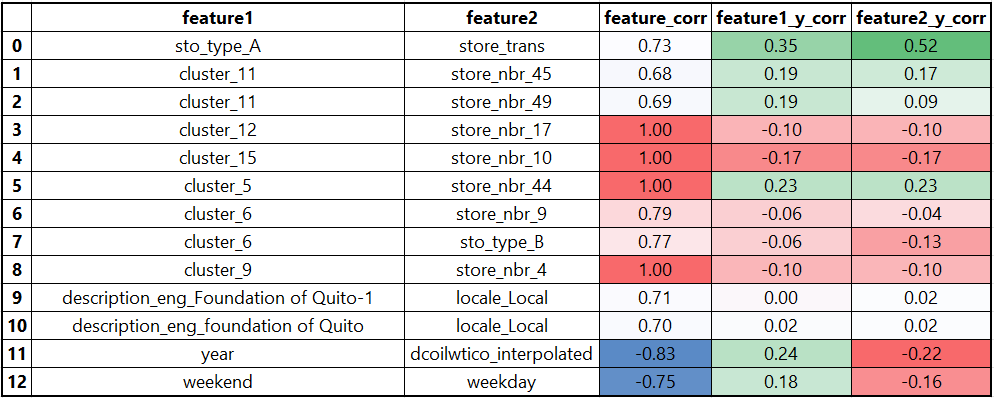

**From the visual, we can see that row 1 to row 4, row 6 to row 10, and row 12 have very low correlation with the target and pretty high collinerity, so these feature pairs can be dropped. Aditionaly for row 0, since feature 2 has higher correlation with the target, let's drop feature 1 from this pair. Same with dcoilwtico_interpolated.**

In [182]:
# check for the row5 feature pair variance
df_X_train_ss["cluster_5"].var()

1.0000085136093915

In [183]:
df_X_train_ss["store_nbr_44"].var()

1.0000085136093915

**cluster_5 and store_nbr_44 have the same variance, here we are dropping cluster_5**

In [184]:
drop_cols = ['sto_type_A', 'cluster_11', 'store_nbr_45', 'store_nbr_49', \
             'cluster_12', 'store_nbr_17', 'cluster_15', 'store_nbr_10', \
             'cluster_5', 'store_nbr_9', 'cluster_6', 'sto_type_B', 'cluster_9', \
             'store_nbr_4', 'description_eng_Foundation of Quito-1', 'locale_Local', \
             'description_eng_foundation of Quito', 'dcoilwtico_interpolated', 'weekend', 'weekday']

In [185]:
# drop the bove mentioned columns
df_X_train_ss_crop = df_X_train_ss.drop(columns=drop_cols)
df_X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)
df_X_test_ss_crop = df_X_test_ss.drop(columns=drop_cols)

In [186]:
# make sure the shapes match
df_X_train_ss_crop.shape

(117460, 96)

In [187]:
y_train.shape

(117460,)

In [188]:
df_X_test_ss_crop.shape

(29365, 96)

In [189]:
y_test.shape

(29365,)

In [190]:
# reset y index to match with X's index
y_train.reset_index(drop=True)

0         2196.000
1         4666.458
2            5.000
3         1483.000
4         4110.576
            ...   
117455    7754.000
117456    5604.967
117457    2883.499
117458    2818.000
117459    3699.000
Name: sales, Length: 117460, dtype: float64

In [191]:
y_test.reset_index(drop=True)

0         438.0
1         552.0
2        1256.0
3         773.0
4        2689.0
          ...  
29360    3332.0
29361    1607.0
29362     769.0
29363    6962.0
29364    2489.0
Name: sales, Length: 29365, dtype: float64

In [192]:
# fit the model using reduced features"
re_lr = LinearRegression()
re_lr.fit(df_X_train_ss_crop,y_train)
score1 = re_lr.score(df_X_train_ss_crop, y_train)
score2 = re_lr.score(df_X_test_ss_crop, y_test)
print(f"Fine Tuned Linear Regression R-squared train score:", round(score1,2))
print(f"Fine Tuned Linear Regression R-squared test score:", round(score2,2))

Fine Tuned Linear Regression R-squared train score: 0.67
Fine Tuned Linear Regression R-squared test score: 0.68


#### Compared with baseline model and PCA model, the test score remains the same. Similar test and train scores suggest a robust model. Let's check other linear regression assumptions.

### 3.2 Model Evaluations

- **Residuals** are normally distributed.
- **Homoscedasticity**: The variance of residual is the same for any value of X.

#### Residuals

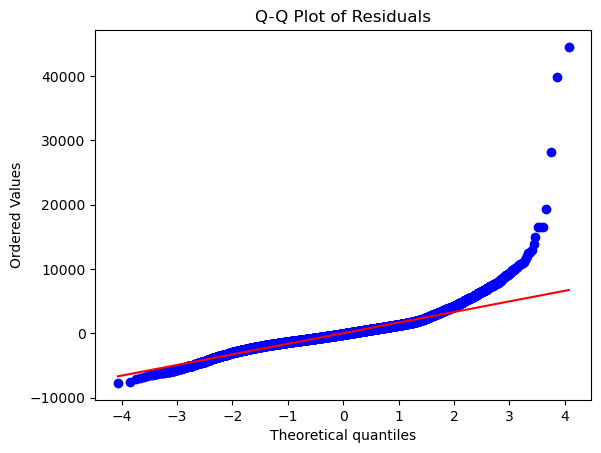

In [193]:
# Plotting the residuals of the model 3.1.2
import scipy.stats as stats
# Calculate residuals
y_test_pred = re_lr.predict(df_X_test_ss_crop)
residuals = y_test - y_test_pred

# Q-Q Plot
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

**The points close to the mean are close to the reference line, suggesting a good fit. However, there is a large gap at the tail, indicating that linear regression might not be the best model for predicting sales. Moving forward, we can try other models.**

#### Homoscedasticity

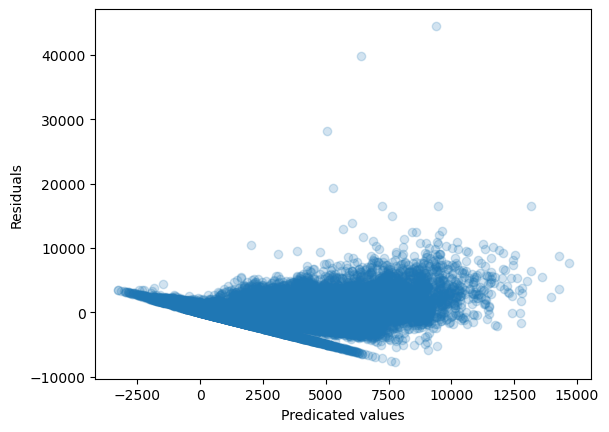

In [198]:
# Plot the residuals and the predicted values
plt.figure()
plt.scatter(y_test_pred, residuals, alpha=0.2)
plt.xlabel('Predicated values')
plt.ylabel('Residuals')
plt.show()

### 4. Conclusion:

**There is clear pattern in the plots, suggesting that the model can not be trusted. From all the previous modeling, we can conclude that Linear Regression is not an ideal model for the prediction. Next step we need to try other models that don't require the assumptions to be met.**

### 5. Other Models:

##### KNN

In [195]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_ss,y_train)
score = knn.score(X_test_ss,y_test)
print(f"Baseline KNN R-squared score:", round(score,2))

Baseline KNN R-squared score: 0.83


##### Random Forest

In [196]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)
score = rf.score(X_test, y_test)
print(f"Baseline Random Forest R-squared score:", round(score,2))

Baseline Random Forest R-squared score: 0.95


#### Neural Network

In [197]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50, ), max_iter=2000, random_state=42) 
mlp.fit(X_train_ss, y_train)
score = mlp.score(X_test_ss, y_test)
print(f"Baseline Neural Network R-squared score:", round(score, 2))

Baseline Neural Network R-squared score: 0.91
